In [1]:
#!/usr/bin/env python -W ignore::DeprecationWarning

import glob, pickle, os, time
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from helper_functions import *
from skimage.feature import hog
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity, equalize_adapthist
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.ndimage.measurements import label

from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


/home/ucalegon/pythoconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### PARAMETERS ###
processed_images = False
clf_train_features_name = None
clf_type = 'xgb'

In [3]:
def load_images_labels(processed_images = False):
    if not processed_images: 
        with open('clf_images/all_vehicles.pickle', 'rb') as f:
            all_vehicles = pickle.load(f)
        f.close()
    else:
        with open('clf_images/all_vehicles_processed.pickle', 'rb') as f:
            all_vehicles = pickle.load(f)
        f.close()

    with open('clf_images/all_vehicles_labels.pickle', 'rb') as f:
        all_vehicles_labels = pickle.load(f)
    f.close()
    
    return all_vehicles, all_vehicles_labels

In [4]:
# Feature gen step - same for both training & prediction

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), orient=12, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in tqdm(imgs):
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image) 

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins) #, bins_range=hist_range
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    feature_names = ['f{}'.format(x) for x in range(len(features[0]))]
    features_df = pd.DataFrame(features, columns = feature_names)
    features_df.sort_index(axis = 1, inplace = True)
    del features
    
    return features_df

In [5]:
def dump_clf(clf, clf_name):
    '''
    Pickle classifier using clf_name
    '''
    if '.pickle' in clf_name:
        pass
    else:
        clf_name += '.pickle'
    with open('clfs/'+clf_name, 'wb') as f:
        pickle.dump(clf, f)
    f.close()
    
    print('Classifier dumped to clfs/{}'.format(clf_name))
    
    return

def load_clf(clf_name):
    with open('clfs/'+clf_name, 'rb') as f:
        clf = pickle.load(f)
    f.close()
    
    return clf
    

In [6]:
def train_clf(features, labels, clf_type = 'xgb', testing = False):
    
    if clf_type == 'xgb':
    
        clf = XGBClassifier()
    
    elif clf_type == 'svc':
        
        params = {
                'kernel': ('linear', 'poly')
                }
        
        svc = SVC()
        clf = GridSearchCV(svc, param_grid = params)
    
    if testing:
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)


        t_0 = time.time()
        print('training...')
        clf.fit(X_train_scaled, y_train)
        t_1 = time.time()
        print('{} clf fit in {:.2f} s'.format(clf_type, t_1-t_0))

        y_test_hat = clf.predict(X_test_scaled)

        accuracy = accuracy_score(y_test, y_test_hat)
        f1 = f1_score(y_test, y_test_hat)
        clf_report = classification_report(y_test, y_test_hat)

        print('Accuracy = {}'.format(accuracy))
        print('f1 Score = {}'.format(f1))
        print('\n')
        print(clf_report)
    
    print('\n')
    print('training on full training set...')
    t_2 = time.time()
    scaler = StandardScaler().fit(features)
    features_scaled = scaler.transform(features)
    clf.fit(features_scaled, labels)
    t_3 = time.time()
    print('{} clf on full training set fit in {:.2f}s'.format(clf_type, t_3-t_2))
    
    
    return clf, scaler

In [7]:
def train_clf_pipeline(testing = True):
    
    images, labels = load_images_labels(processed_images = processed_images)
    
    if os.path.isfile('clf_images/all_vehicles_features.pickle'):
        features_df = pd.read_pickle('clf_images/all_vehicles_features.pickle')
        print('features loaded from pickle')
    else:
        features_df = extract_features(images)
        features_df.to_pickle('clf_images/all_vehicles_features.pickle')
        
    clf, scaler = train_clf(features_df, labels, clf_type = 'xgb')
    #clf = train_clf(features_df, labels, clf_type = 'svc')
    clf_name = '{0}_{1}'.format(clf_type, time.strftime('%m-%d-%H-%M'))+'.pickle'
    dump_clf(clf, clf_name)
    dump_clf(scaler, 'scaler.pickle')

In [8]:
#train_clf_pipeline(testing = False)

In [9]:
# For processing new image

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, window_dict, x_overlap=0.75):
    window_list = []
    for y_end in window_dict.keys():
        for win_h in window_dict[y_end]:
            y_start = min(y_end-win_h, img.shape[0])
            x_start = 0
            x_end = min(x_start+win_h, img.shape[1])
            while x_end < img.shape[1]:
                window = ((x_start, y_start), (x_end, y_end))
                window_list.append(window)
                x_start += int(win_h*(1-x_overlap))
                x_end = min(x_start+win_h, img.shape[1])
            x_start = img.shape[1] - win_h
            x_end = img.shape[1]
            window = ((x_start, y_start), (x_end, y_end))
            window_list.append(window)
            
    # Return the list of windows
    return window_list



In [10]:
image = mpimg.imread('test_images/detection_testing/frame_43.png')

window_dict = {
                448: [48],
                472: [64, 72],
                488: [72, 96],
                504: [96, 128],
                520: [96, 128],
                536: [96, 128],
                552: [96, 128, 144, 160],
                576: [144, 160, 192],
                588: [144, 160, 192],
                600: [160, 192],
                624: [192, 216],
                648: [192, 216],
                660: [192, 216]
                }

windows = slide_window(image, window_dict, x_overlap=0.25)
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    


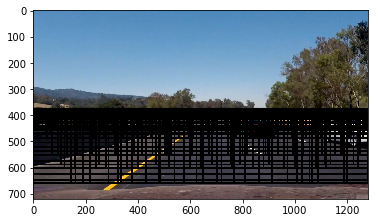

In [11]:
plt.imshow(window_img)

In [12]:
def detect_cars(img, windows, clf, scaler):
    features = []
    sub_imgs = []
    img = img_as_ubyte(rescale_intensity(img))
    for window in tqdm(windows):
        sub_img = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        sub_img = img_as_ubyte(resize(rescale_intensity(sub_img), (64, 64, 3)))
        sub_imgs.append(sub_img)
    features_df = extract_features(sub_imgs)
    features_scaled = scaler.transform(features_df)
    window_hats = []
    predictions = clf.predict(features_scaled)
    
    window_inds = (predictions == 1)
    for i in range(len(window_inds)):
        if window_inds[i]:
            window_hats.append(windows[i])        
    return window_hats, features_scaled, predictions, sub_imgs

    
    

In [13]:
clf_name = 'xgb_06-19-22-36.pickle'
clf = load_clf(clf_name)
scaler_name = 'scaler.pickle'
scaler = load_clf(scaler_name)

In [14]:
window_hats, features_scaled, predictions, sub_imgs = detect_cars(image, windows, clf, scaler)


100%|██████████| 411/411 [00:03<00:00, 134.57it/s]


In [15]:
pd.Series(predictions).value_counts()

0.0    411
dtype: int64

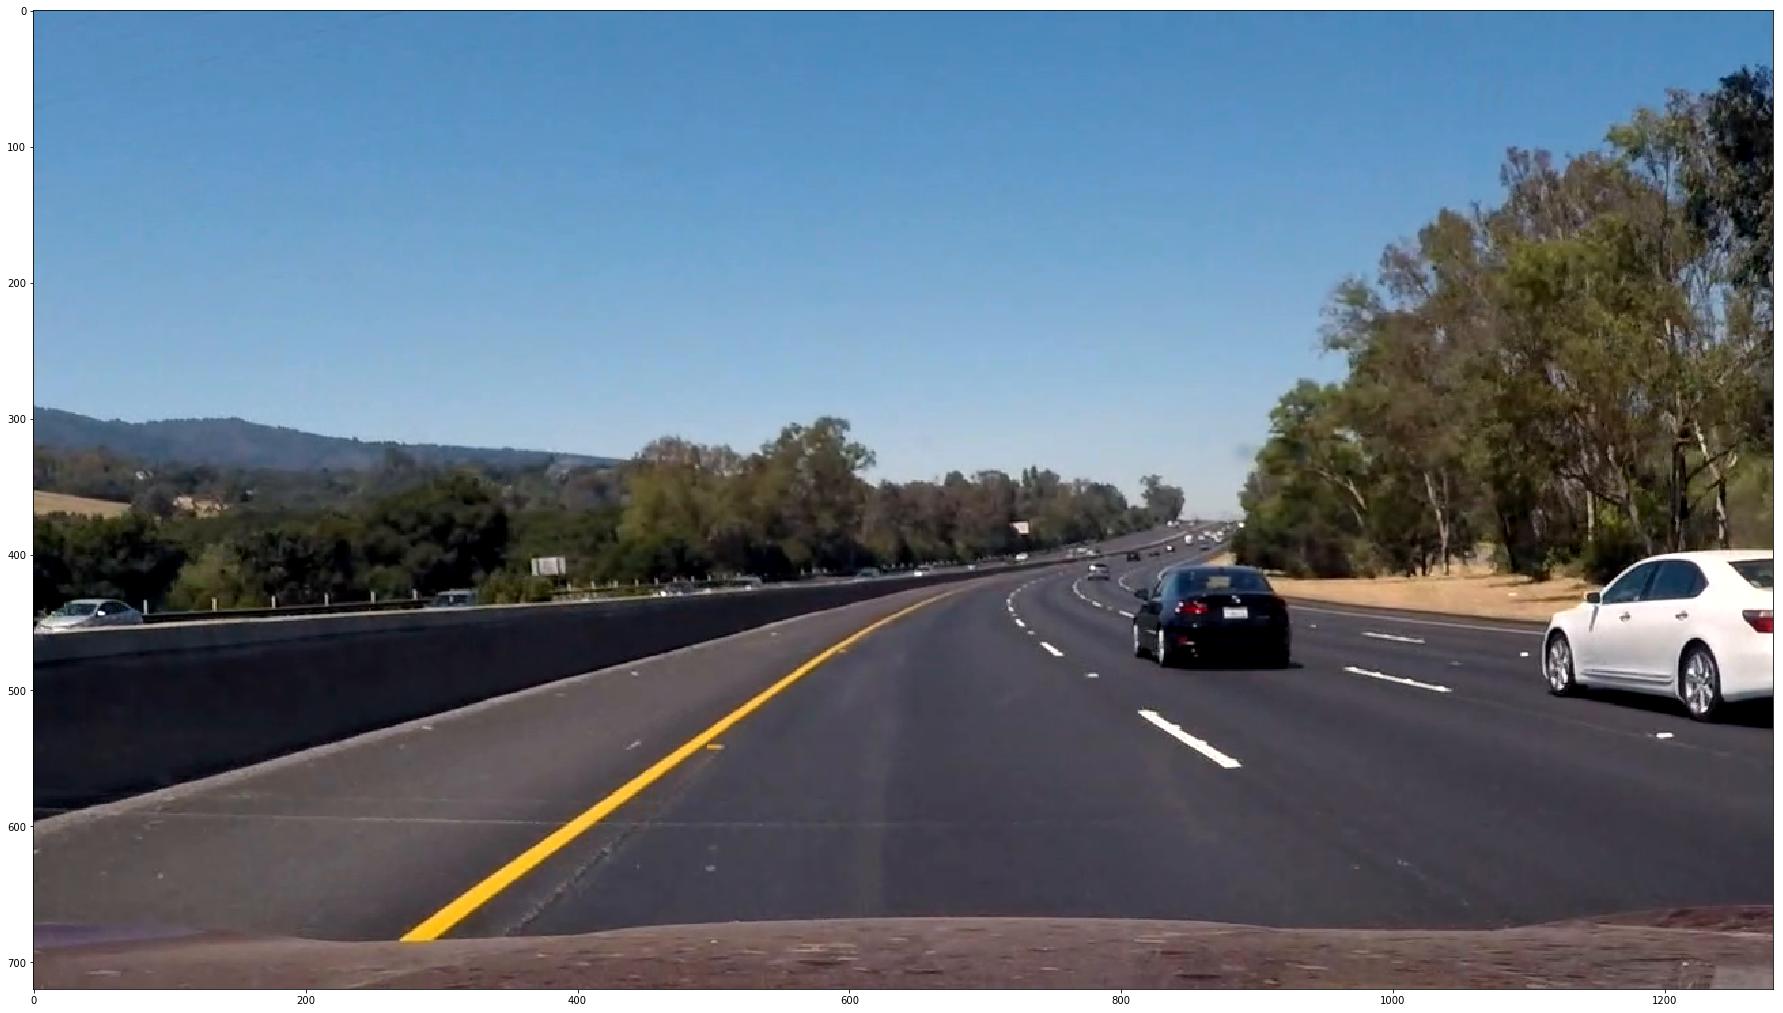

In [16]:
window_hat_img = draw_boxes(image, window_hats)
fig, ax = plt.subplots(1,1,figsize = (32, 18))

ax.imshow(window_hat_img)

In [17]:
window_hats

[]

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def expand_labeled_bboxes(labels, windows_hat):
    
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        print(nonzero)
        return nonzero

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        print(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 4)
    # Return the image
    return img


In [ ]:
heatmap = np.zeros(image.shape[:2])
heatmap = add_heat(heatmap, window_hats)

fig, ax = plt.subplots(1,1, figsize = (16, 9))
ax.imshow(heatmap)

In [ ]:
heat_thresh = 3
heatmap_threshd = apply_threshold(heatmap, heat_thresh)

labels = label(heatmap_threshd)

fig, ax = plt.subplots(1,1,figsize = (32,18))
ax.set_title('{} cars found'.format(labels[1]), fontsize = 32)
ax.imshow(labels[0])

In [ ]:
nonzero = expand_labeled_bboxes(labels, window_hats)

In [ ]:
for bbox in window_hats:
    if

In [ ]:
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig, ax = plt.subplots(1,1,figsize = (32,18))
ax.imshow(draw_img)